## Property fields in `curlew`

In [1]:
# Import the necessary libraries
import curlew
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import cmasher as cmr
import torch
import random

# The necessary sub-modules
from curlew import GeoModel
from curlew.geology import strati, fold
from curlew.fields.analytical import ALF
from curlew.visualise import plot2D

# curlew.geometry allows us to define grids for model evaluation
from curlew.geometry import grid
from curlew_helper import plotDrill, plotConstraints

# Change this to "cpu" if you don't have CUDA cores
curlew.device = 'cpu'
curlew.dtype = torch.float32

In [2]:
# Plotting params
from matplotlib import colors as mcolors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['./Helvet/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-2, 2]

# Curlew colormap
import matplotlib.colors as mcolors

# Define the colors extracted manually from the provided logo image
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)

# Random seed
random.seed(42)

In [3]:
from curlew.data import hutton

# Let us define a domain and a grid within the domain
dims = (1500,700)
_, gxy = grid(dims, step=(1,1), origin=(0,0)) 

_, _, C, analytical_M = hutton(dims, breaks=5, cmap=cmr.neon, pval=0.5, xstep=220)
# Remove constraints from the basement
C[0].gp = C[0].gp[::3]
C[0].gv = C[0].gv[::3]
C[0].gop = C[0].gop[::3]
C[0].gov = C[0].gov[::3]

In [4]:
from curlew import HSet
from curlew.geology import strati, GeoModel

# grid for evaluating global losses
# define a grid of control points to evaluate our "global" losses
from curlew.geometry import grid
_, cxy = grid( dims, step=(100,100), origin=(0,0) ) 
for _C in C: 
    _C.grid = cxy # add grid to each of our constraints


# define interpolator for basement field
H = HSet( value_loss='1.0', mono_loss="0.01", thick_loss='0.01', softadapt=0)
s0 = strati('basement', # name for this scalar field
            C[0], # constraints for this field
            H, # interpolator hyperparameters
            base=-np.inf, # basal surface (important for unconformities)
            input_dim=2, # field input coordinate dimensions (2D in our case)
            hidden_layers=[32,], # hidden layers in the multi-layer perceptron that parameterises our field
            rff_features=64, # number of random sin and cos features to create for each scale 
            length_scales=[500,]) # the length scales in our model

# define interpolator for unconformity field
s1 = strati('unconformity', # name of created structural field (SF)
            C[1], # constraints for this field
            H.copy(value_loss='1.0', mono_loss="0.01", thick_loss="0.1", softadapt=0), # change some hyperparams
            base=10.0, # basal surface (important for unconformities). In this case these have a value of 0.
            input_dim=2, # field input coordinate dimensions (2D in our case)
            hidden_layers=[32], # hidden layers in the multi-layer perceptron that parameterises our field
            rff_features=64, # number of random sin and cos features to create for each scale 
            length_scales=[2000,]) # the length scales in our model

In [5]:
# combine into a geomodel
M = GeoModel([s0,s1]) 

# fit scalar fields independently
loss = M.prefit(epochs=1500)

unconformity: 1500/1500|, value_loss=3.64e-6, grad_loss=6.86e-6, thick_loss=0.000242, mono_loss=1.49e-5 
basement: 1275/1500|, value_loss=3.57e-5, grad_loss=9.31e-5, thick_loss=0.00172, mono_loss=0.00356   


In [6]:
# evaluate scalar field
pred_wo_prop = M.predict(gxy)

In [7]:
from curlew import NF
from torch import nn

# create a forward model (NF instance)
M.forward = NF(HSet().zero(prop_loss="1.0"), # zero all hyperparams except property loss
               name = 'forward', 
               input_dim=3, # two inputs - (scalar_value, field_id )
               output_dim=3, # one output for each measured property [ R, G, B ]
               hidden_layers=[1024, 2048, 512], # build a bigger network here; we need nonlinearity
               activation=nn.ReLU(), # this is a more conventional MLP
               loss=nn.L1Loss(),# nn.L1Loss(), # play with the loss function -- it makes quite a big difference!
               rff_features=0) # don't use fourier features

M.forward.bind(C[-1]) # add property constraints 
                      # (in this case all our fields have property constraints)

In [ ]:
# now train everything together, to let geometry adapt given the forward model!
# M.freeze([s1], geometry=True) # keep unconformity geometry fixed as we already like it :-) 
loss = M.fit(2000, learning_rate=1e-4)

Training: 2000/2000|, unconformity=0.000389, basement=0.00955, forward=13.6


In [9]:
# evaluate scalar field
pred = M.predict(gxy)
# spred has two columns, with SF Value and Event ID
svalue = torch.tensor(pred[:, 0], device=curlew.device, dtype=curlew.dtype).unsqueeze(1)
eid = torch.tensor(pred[:, 1] - 1, device=curlew.device, dtype=torch.long)
# One-hot encode the values
num_events = 2
event_one_hot = torch.nn.functional.one_hot(eid, num_classes=num_events).float()
# Property Field input
pfield_input = torch.cat((svalue*1e-2, event_one_hot), dim=1)
# evaluate predicted property field using forward model
ppred = M.forward.predict(pfield_input)

In [10]:
# Get the original scalar field
original_field = analytical_M.predict(gxy)

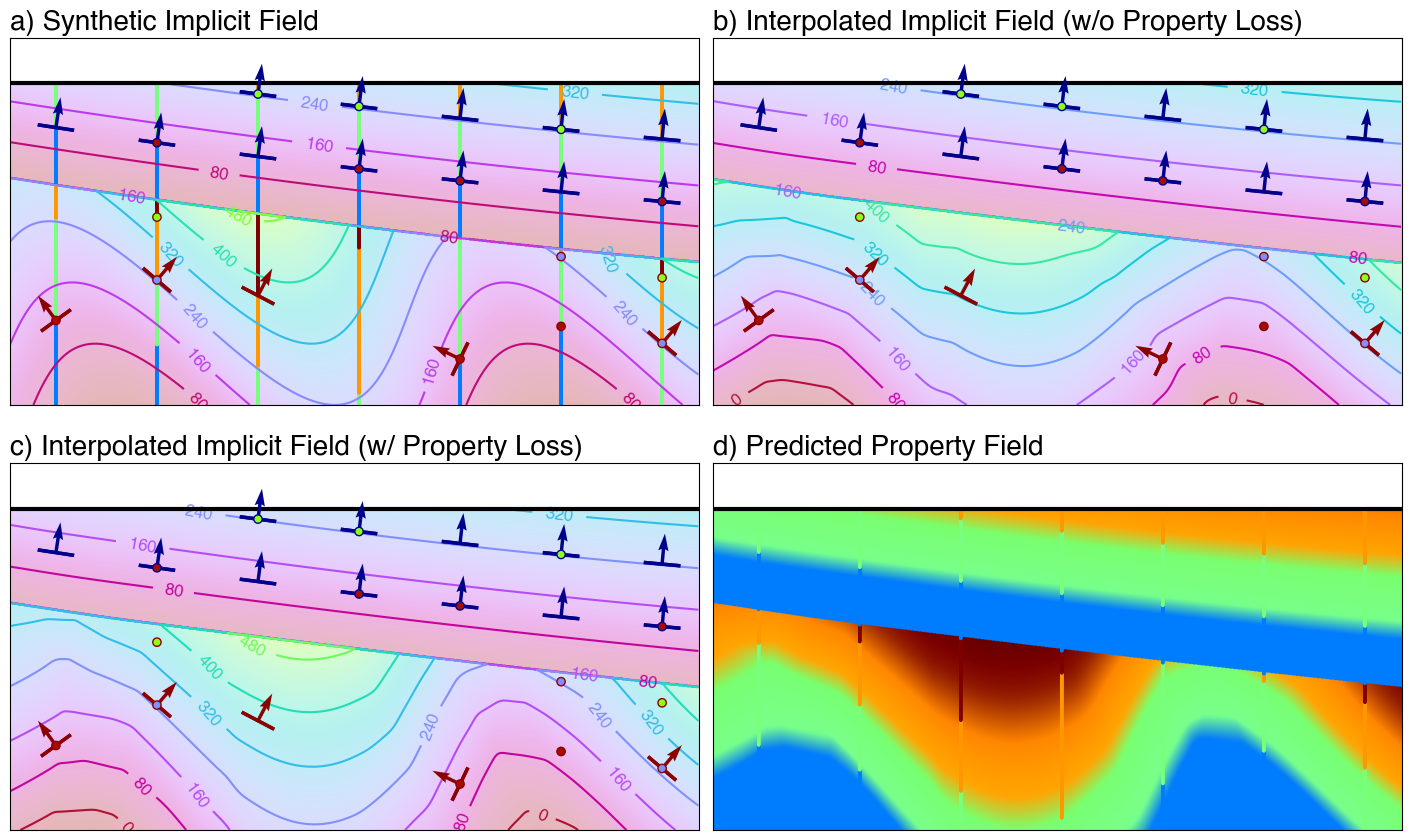

In [11]:
# Plot the model!
fig,ax = plt.subplots(2, 2, figsize=(14, 8.5), sharex=True, sharey=True, layout="constrained")

# Define colormap
sfield_cm = cmr.neon

# Plot the original implicit field and the constraints
plot2D(gxy, original_field[:, 0], dims, ax=ax.ravel()[0], cmap=sfield_cm)
plotConstraints(ax.ravel()[0], C[0], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkred"], vmn=None, cmap=sfield_cm)
plotConstraints(ax.ravel()[0], C[1], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkblue"], vmn=None, cmap=sfield_cm)
plotConstraints(ax.ravel()[0], C[2])

# Plot the predicted field without property constraints
plot2D(gxy, pred_wo_prop[:, 0], dims, ax=ax.ravel()[1], cmap=sfield_cm)
plotConstraints(ax.ravel()[1], C[0], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkred"], vmn=None, cmap=sfield_cm)
plotConstraints(ax.ravel()[1], C[1], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkblue"], vmn=None, cmap=sfield_cm)
# Plot it with property constraints
plot2D(gxy, pred[:, 0], dims, ax=ax.ravel()[2], cmap=sfield_cm)
plotConstraints(ax.ravel()[2], C[0], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkred"], vmn=None, cmap=sfield_cm)
plotConstraints(ax.ravel()[2], C[1], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkblue"], vmn=None, cmap=sfield_cm)
# Plot the predicted property field
plot2D(gxy, np.clip(ppred/255,0,1), dims, ax=ax.ravel()[3], cmap="seismic", alpha=1, levels=False)
plotConstraints(ax.ravel()[3], C[2])

# Set titles
ax.ravel()[0].set_title("a) Synthetic Implicit Field", loc="left")
ax.ravel()[1].set_title("b) Interpolated Implicit Field (w/o Property Loss)", loc="left")
ax.ravel()[2].set_title("c) Interpolated Implicit Field (w/ Property Loss)", loc="left")
ax.ravel()[3].set_title("d) Predicted Property Field", loc="left")

# Plot the drill holes
# for hole in holes:
#     plotDrill(hole, ax=ax[1], lw=4, ticksize=0, vmn=vmn, vmx=vmx, cmap=colormap)
    
ax.ravel()[0].axhline(700, c="k", lw=3, zorder=9)
ax.ravel()[1].axhline(700, c="k", lw=3, zorder=9)
ax.ravel()[2].axhline(700, c="k", lw=3, zorder=9)
ax.ravel()[3].axhline(700, c="k", lw=3, zorder=9)

'''
ax[1].text(0.95, 0.65,  # x and y in axes fraction (0 to 1)
                          r"$\mathbf{e_1 = Unconformity}$",
                          transform=ax[1].transAxes,
                          verticalalignment='center', fontsize=20,
                          horizontalalignment='right', color="w",
                          zorder=10
                         )
ax[1].text(0.95, 0.23,  # x and y in axes fraction (0 to 1)
                          r"$\mathbf{e_0 = Basement}$",
                          transform=ax[1].transAxes,
                          verticalalignment='center', fontsize=20,
                          horizontalalignment='right', color="w",
                          zorder=10
                         )
'''
    
# Make the plot prettier
_ = [ax_.set_xticks([]) for ax_ in ax.ravel()]
_ = [ax_.set_aspect("equal") for ax_ in ax.ravel()]
ax.ravel()[0].set_ylim([0, dims[1]+100])
ax.ravel()[0].set_xlim([0, dims[0]])
_ = [ax_.set_yticks([]) for ax_ in ax.ravel()]

# Save the figure!
plt.savefig("./Figures/Interpolated_Hutton_Property.png", dpi=300)
plt.show()